In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
import os
sys.path.append("..")
from lib import data
import torch
torch.manual_seed(13) # Set random seed
from torch import nn
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm

from lib import data
from lib import sar
from lib import io

from torch.utils.data import Dataset
from loguru import logger
from lib.datamodules.components.patches import PatchesDataset
from lib.datamodules.patches import PatchesDataModule
from lib.model import mlp_cnn
from lib.datamodules import dataset

# model download

- https://sar-recovery.s3.us-west-2.amazonaws.com/models/model_convs5_1024_512_MLP3.npz
- https://sar-recovery.s3.us-west-2.amazonaws.com/models/model_convs5_1024_512_MLP3.pt

# data params


In [195]:
base_path = "/home/rlx/data/sar-recovery"
#base_path = "/home/alberto/data/data/RST2/Barcelona"
date_train = '20100520'
date_test  = '20120720'

#date_test = '20100520'
#date_train  = '20120720'

window_size = 7

model_fname = "model_convs5_1024_512_MLP3.pt"
model_losses_fname = model_fname.split('.')[0] + ".npz"

# load data


In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

# create used matrices (without log)


In [4]:
cm3x3tr = torch.tensor((cmtr))
cm3x3ts = torch.tensor((cmts))
cm2x2tr = torch.tensor((cmtr[...,1:3, 1:3]))
cm2x2ts = torch.tensor((cmts[...,1:3, 1:3]))
cm3x3tr.shape, cm2x2tr.shape

(torch.Size([628, 228, 3, 3]), torch.Size([628, 228, 2, 2]))

# split mask


In [5]:
h, w = cmtr.shape[:2]
splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)
TRAIN, TEST, VAL = 0,1,2

# use data loader

In [6]:
dp = PatchesDataModule(
        input_train_image  = cm2x2tr,
        output_train_image = cm3x3tr,
        input_test_image   = cm2x2ts,
        output_test_image  = cm3x3ts,
        input_val_image    = cm2x2ts,
        output_val_image   = cm3x3ts,
        patch_size  = 15,
        batch_size  = 32,
        splitmask   = splitmask_bands,
        shuffle_train = True,
        shuffle_test  = True,
        shuffle_val   = True
)

2024-05-30 20:02:29.898 | INFO     | lib.datamodules.patches:__init__:52 - PatchesDataset              patch_size=15  splitmask_dims=(628, 228)
original split proportions: train=0.713  test=0.143  val=0.143
patch split proportions:    train=0.714  test=0.143  val=0.143
        


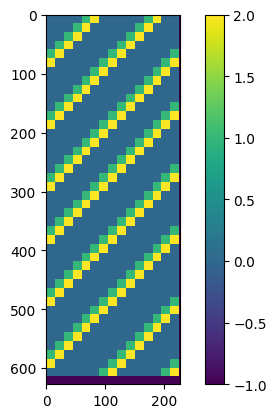

In [7]:
dp.train_dataset.plot_split()

In [8]:
dts = dp.test_dataloader()

In [9]:
# normally one would iterate over the full dataset
# here, we stop at the first batch to inspect it
for item in dts:
    break

In [10]:
# observe that a batch is a dictionary of patches and their coordinates in the original image
item.keys()

dict_keys(['input_patch', 'output_patch', 'patch_coords'])

In [11]:
# batches of shape: [batch_size, patch_size, patch_size, ...]
item['input_patch'].shape, item['output_patch'].shape, item['patch_coords'].shape

(torch.Size([32, 15, 15, 2, 2]),
 torch.Size([32, 15, 15, 3, 3]),
 torch.Size([32, 2]))

In [12]:
# Indices upper triangular matrix for 2x2 and 3x3 matrices
c2tri_x1, c2tri_x2 = torch.triu_indices(2, 2)
c3tri_x1, c3tri_x2 = torch.triu_indices(3, 3)

transforms_in = transforms.Compose([
    dataset.Matrix_TraceNormRhos_parametrization(),
    #dataset.Matrix_Cholesky_parametrization(),
    #dataset.GetMatrixElements_RealAndImag([0,0,1], [0,1,1]),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transforms_out = transforms.Compose([
    #dataset.Matrix_TraceNormRhos_parametrization(),
    dataset.Matrix_Cholesky_parametrization(),
    #dataset.GetMatrixElements_RealAndImag([0,0,0,1,1,2], [0,1,2,1,2,2]),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

#recover_C_matrix = dataset.RecoverMatrix_From_TraceNormRhos_parametrization(3)
recover_C_matrix = dataset.RecoverMatrix_From_Cholesky_parametrization(3)

print(f"Input shape:  {transforms_in(item['input_patch']).shape}")
print(f"Output shape: {transforms_out(item['output_patch']).shape}")

Input shape:  torch.Size([32, 15, 15, 5])
Output shape: torch.Size([32, 15, 15, 9])


In [13]:
print(f"Input type:  {item['input_patch'].dtype}")
print(f"Output type: {item['output_patch'].dtype}")

Input type:  torch.complex64
Output type: torch.complex64


In [14]:
# Test that we can recover covariance matrix from the individual elements
print(recover_C_matrix( transforms_out(item['output_patch'] )).shape)
torch.allclose(item['output_patch'], recover_C_matrix(transforms_out(item['output_patch'])), rtol=5e-5)

torch.Size([32, 15, 15, 3, 3])


True

# Train MLP Conv2d- Matrix Norm parametrization with the Revised Wishart distance as a loss function

**input**: The TraceNormRhos parametrization contains the log of the trace $\log tr(\mathbf{C}_2)$, the normalized diagonal powers $d_1, d_2 = diag(\mathbf{C}_2) / tr(\mathbf{C}_2)$, and the correlation coeficients from the 2 by 2 subcovariance matrix corresponding to HV and VV polarizations $\mathbf{L} = \log \mathbf{C}_{22 - 33}$ (5 real values: $\log tr, d_1, d_2, \Re(\rho_{12}), \Im(\rho_{12})$):

$\begin{equation}
  \mathbf{C}_N = \begin{bmatrix}
    \frac{1}{\sqrt{C_{11}}} & 0\\
    0 & \frac{1}{\sqrt{C_{22}}}
    \end{bmatrix}
    \mathbf{C}_2
    \begin{bmatrix}
    \frac{1}{\sqrt{C_{11}}} & 0\\
    0 & \frac{1}{\sqrt{C_{22}}}
    \end{bmatrix} = 
    \begin{bmatrix}
    1 & \rho_{12}\\
    \rho_{12}^* & 1
    \end{bmatrix}
\end{equation}$

**output**: The Cholesky factorization of the 3 by 3 covariance matrix $\mathbf{L}$, where $\mathbf{L}$ is a lower triangular matrix such that $\mathbf{C} = \mathbf{L}\mathbf{L}^H$ (9 real values: $L_{11}, L_{22}, L_{33}, \Re(L_{21}), \Re(L_{31}), \Re(L_{23}), \Im(L_{21}), \Im(L_{31}), \Im(L_{23})$)

**loss**: The Revised Wishart dissimilarity function (non Symetric) will be used as a loss function:

$d_{RW}(\mathbf{X}, \mathbf{Y}) = \log \frac{|\mathbf{Y}|}{|\mathbf{X}|} + tr(\mathbf{Y}^{-1} \mathbf{X}) - p$

**Note**: Since the matrix logarithm depends on the whole covariance matrix, it is not the same to perform the logarithm of the 3x3 covariance matrix and take the 2x2 submatrix than doing the logarithm of the 2x2 submatrix

In [15]:
# Decide which device we want to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [206]:
# Define the model
N_hiden_layers = 3
Hiden_size = 1024

## Model with Normalization
#model = nn.Sequential(
#    mlp_cnn.MLP_Conv2d(5,10, [Hiden_size] * N_hiden_layers, normalization=nn.BatchNorm2d),
#    dataset.TraceNormRhosActivarion(3))

# Model with Normalization
#model = nn.Sequential(
#    mlp_cnn.MLP_Conv2d(5,9, [Hiden_size] * N_hiden_layers, normalization=nn.BatchNorm2d),
#    dataset.NormRhosActivarion(3))

#model = mlp_cnn.MLP_Conv2d(5,9, [Hiden_size] * N_hiden_layers, normalization=nn.BatchNorm2d)

model = nn.Sequential(
    nn.Conv2d(5, Hiden_size, kernel_size=(5,5), padding="same", bias=False,
              #padding_mode='reflect'
             ),
    nn.BatchNorm2d(Hiden_size),
    nn.ReLU(),

    nn.Conv2d(Hiden_size, Hiden_size//2, kernel_size=(5,5), padding="same", bias=False,
              #padding_mode='reflect'
             ),
    nn.BatchNorm2d(Hiden_size//2),
    nn.ReLU(),
    
    mlp_cnn.MLP_Conv2d(Hiden_size//2, 9, [Hiden_size//2] * N_hiden_layers, normalization=nn.BatchNorm2d,
                       #activation=nn.GELU,
                       #dropout=0.1,
                      ),
    )

model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(5, 1024, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(1024, 512, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MLP_Conv2d(
    (model): Sequential(
      (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Con

In [202]:
# Define loss function
#loss_fn = dataset.FrobeniusNormMeanSquaredLoss()
#loss_fn = dataset.FrobeniusNormRelativeMeanSquaredLoss()
#loss_fn = dataset.SymmetricRevisedWishartLoss(eps=1e-5)
#loss_fn = dataset.SymmetricRevisedWishartLoss_RelPreload(rel_eps=1e-4)
loss_fn = dataset.RevisedWishartLoss()
#loss_fn = dataset.WishartLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [203]:
def train_one_epoch(training_loader):
    running_loss = 0.
    model.train(True)
    for i, data in enumerate(training_loader):
        # Load and prepare data
        inputs, desired_output = data['input_patch'], data['output_patch']
        
        # Apply transforms & prepare data
        #inputs = torch.moveaxis(transforms_in(inputs), -1, -3)
        inputs = torch.moveaxis(torch.as_tensor(transforms_in(inputs)), -1, -3)
        #desired_output = torch.moveaxis(transforms_out(desired_output), -1, -3)

        # Move data to device
        inputs = inputs.to(device)
        #desired_output = desired_output.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Convert outputs to C matrices again
        Cout = recover_C_matrix(torch.moveaxis(outputs, -3, -1))
        #Cn = recover_C_matrix(torch.moveaxis(outputs, -3, -1))
        #trin = torch.exp(inputs[..., 0, :, :])
        #tr = trin / (Cn[..., 1, 1] + Cn[..., 2, 2])
        #Cout = tr[..., None, None] * Cn

        #Cdesired = recover_C_matrix(torch.moveaxis(desired_output, -3, -1))
        Cdesired = data['output_patch'].to(device)

        # Compute the loss and its gradients
        #loss = loss_fn(Cout, Cdesired)
        #loss = loss_fn(Cdesired, Cout)
        #loss = torch.log1p(loss_fn(Cout, Cdesired))
        #loss = torch.log1p(loss_fn(Cdesired, Cout))
        #loss = loss_fn(Cout, Cdesired).mean()
        loss = torch.log1p(loss_fn(Cout, Cdesired)).mean()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        #running_loss += loss.item()
        running_loss += torch.expm1(loss.detach()).item()
    
    return running_loss / len(training_loader)

def evaluate_test(test_loader):
    running_loss = 0.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Every data instance is an input + label pair
            inputs, desired_output = data['input_patch'], data['output_patch']
            
            # Apply transforms & prepare data
            #inputs = torch.moveaxis(transforms_in(inputs), -1, -3)
            inputs = torch.moveaxis(torch.as_tensor(transforms_in(inputs)), -1, -3)
            #desired_output = torch.moveaxis(transforms_out(desired_output), -1, -3)

            # Move data to device
            inputs = inputs.to(device)
            #desired_output = desired_output.to(device)
            
            # Make predictions for this batch
            outputs = model(inputs)
    
            # Convert outputs to C matrices again
            Cout = recover_C_matrix(torch.moveaxis(outputs, -3, -1))
            #Cn = recover_C_matrix(torch.moveaxis(outputs, -3, -1))
            #trin = torch.exp(inputs[..., 0, :, :])
            #tr = trin / (Cn[..., 1, 1] + Cn[..., 2, 2])
            #Cout = tr[..., None, None] * Cn

            #Cdesired = recover_C_matrix(torch.moveaxis(desired_output, -3, -1))
            Cdesired = data['output_patch'].to(device)
    
            # Compute the loss
            #loss = loss_fn(Cout, Cdesired)
            #loss = loss_fn(Cdesired, Cout)
            #loss = loss_fn(Cout, Cdesired).mean()
            loss = torch.log1p(loss_fn(Cout, Cdesired)).mean()
    
            # Gather data and report
            #running_loss += loss.item()
            running_loss += torch.expm1(loss).item()
    
    return running_loss / len(test_loader)


In [204]:
N_epochs = 300

dtr = dp.train_dataloader()
dts = dp.test_dataloader()

losses_train = []
losses_test = []

if True: #not os.path.exists(model_fname):
    print(f"Model file '{model_fname}' not found. Training the model...")
    for i in tqdm(range(N_epochs)):
        # Train
        avg_loss = train_one_epoch(dtr)
        losses_train.append(avg_loss)
        # Test
        avg_loss = evaluate_test(dts)
        losses_test.append(avg_loss)
else:
    print(f"Model file '{model_fname}' found. Loading the pretrained model from there!")
    model.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu') ))
    with np.load(model_losses_fname) as f:
        losses_train = f['losses_train']
        losses_test = f['losses_test']

Model file 'model_convs_MLP3_raul.pt' not found. Training the model...


100%|█████████████████████████████████████████████████████████████████████| 300/300 [02:06<00:00,  2.38it/s]


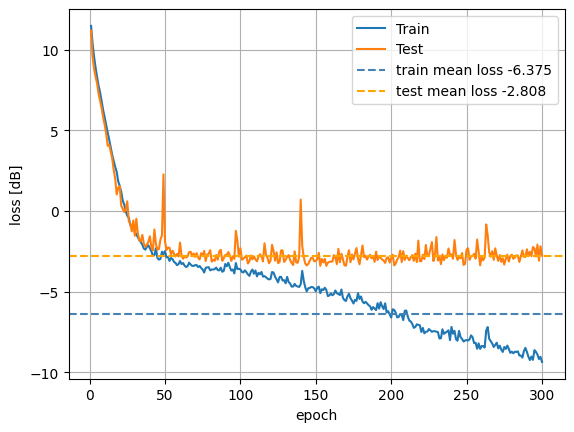

In [173]:
plt.figure()
plt.plot(np.arange(1, len(losses_train)+1), 10*np.log10(losses_train), label="Train")
plt.plot(np.arange(1, len(losses_train)+1), 10*np.log10(losses_test), label="Test")
plt.xlabel("epoch")
plt.ylabel("loss [dB]")

mean_loss_train =  np.mean(10*np.log10(losses_train[-200:]))
mean_loss_test  =  np.mean(10*np.log10(losses_test[-200:]))
plt.axhline( mean_loss_train, color='steelblue', ls='--', label=f"train mean loss {mean_loss_train:.3f}")
plt.axhline( mean_loss_test, color='orange', ls='--', label=f"test mean loss {mean_loss_test:.3f}")
plt.legend()
plt.grid()

In [197]:
torch.save(model, model_fname)